# Prot T5 Finetuning
# per protein prediction

This notebook allows you to finetune PLMs to your own datasets

For better perfomance we apply [Parameter-Efficient Fine-Tuning (PEFT)](https://huggingface.co/blog/peft). For this we apply [LoRA: Low-Rank Adaptation of Large Language Models](https://arxiv.org/abs/2106.09685).

The core training loop is implemented with the pytorch [huggingface trainer](https://huggingface.co/docs/transformers/main_classes/trainer).

In case it is needed for higher memory efficiency, we utilize the [deepspeed](https://github.com/microsoft/DeepSpeed) implementation of [huggingface](https://huggingface.co/docs/accelerate/usage_guides/deepspeed).

## Imports and env. variables

In [3]:
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable
  Using cached transformers-4.50.3-py3-none-any.whl (10.2 MB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [6]:
!pip install datasets

Defaulting to user installation because normal site-packages is not writeable
  Using cached datasets-3.5.0-py3-none-any.whl (491 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
  Using cached multiprocess-0.70.16-py310-none-any.whl (134 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 68.7 MB/s eta 0:00:0000:0100:01
  Using cached requests-2.32.3-py3-none-any.whl (64 kB)
  Using cached fsspec-2024.12.0-py3-none-any.whl (183 kB)
  Using cached dill-0.3.8-py3-none-any.whl (116 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.2.0
    Uninstalling fsspec-2025.2.0:
      Successfully uninstalled fsspec-2025.2.0
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are inst

In [2]:
#import dependencies
import os.path
#os.chdir("set working path here")


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from torch.utils.data import DataLoader

import re
import numpy as np
import pandas as pd
import copy

import transformers, datasets
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers.models.t5.modeling_t5 import T5Config, T5PreTrainedModel, T5Stack
from transformers.utils.model_parallel_utils import assert_device_map, get_device_map
from transformers import T5EncoderModel, T5Tokenizer
from transformers import EsmModel, AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, set_seed

import peft
from peft import get_peft_config, PeftModel, PeftConfig, inject_adapter_in_model, LoraConfig

from evaluate import load
from datasets import Dataset

from tqdm import tqdm
import random

from scipy import stats
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

In [3]:
# Set environment variables to run Deepspeed from a notebook
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "9994"  # modify if RuntimeError: Address already in use
os.environ["RANK"] = "0"
os.environ["LOCAL_RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"

# Environment to run this notebook


These are the versions of the core packages we use to run this notebook:

In [4]:
print("Torch version: ",torch.__version__)
print("Cuda version: ",torch.version.cuda)
print("Numpy version: ",np.__version__)
print("Pandas version: ",pd.__version__)
print("Transformers version: ",transformers.__version__)
print("Datasets version: ",datasets.__version__)

Torch version:  2.0.1
Cuda version:  11.7
Numpy version:  1.22.3
Pandas version:  1.5.3
Transformers version:  4.26.1
Datasets version:  2.9.0


**For easy setup of this conda environment you can use the finetuning.yml File provided in this folder**

check here for [setting up env from a yml File](https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file)

# Model checkpoints

This notebook was tested with all models mentioned below.
All required, model specific adaptations will be taken care of.

In [5]:
ESMs = ["facebook/esm2_t6_8M_UR50D",
         "facebook/esm2_t12_35M_UR50D",
         "facebook/esm2_t30_150M_UR50D",
         "facebook/esm2_t33_650M_UR50D",
         "facebook/esm2_t36_3B_UR50D"]

T5s = ["Rostlab/prot_t5_xl_uniref50",
       'Rostlab/ProstT5',
       "ElnaggarLab/ankh-base",
       "ElnaggarLab/ankh-large"]

### Select your model:

In [49]:
checkpoint = T5s[0]

# Input data

Provide your training and validation data in seperate pandas dataframes 

example shown below

In [6]:
# For this example we import the "three_vs_rest" GB1 dataset from https://github.com/J-SNACKKB/FLIP
# For details, see publication here: https://openreview.net/forum?id=p2dMLEwL8tF
import requests
import zipfile
from io import BytesIO

# Download the zip file from GitHub
url = 'https://github.com/J-SNACKKB/FLIP/raw/main/splits/gb1/splits.zip'
response = requests.get(url)
zip_file = zipfile.ZipFile(BytesIO(response.content))

# Load the `three_vs_rest.csv` file into a pandas dataframe
with zip_file.open('splits/three_vs_rest.csv') as file:
    df = pd.read_csv(file)

In [7]:
# Drop test data
df=df[df.set=="train"]

# Get train and validation data
my_train=df[df.validation!=True].reset_index(drop=True)
my_valid=df[df.validation==True].reset_index(drop=True)

# Set column names to "sequence" and "label"
my_train.columns=["sequence","label"]+list(my_train.columns[2:])
my_valid.columns=["sequence","label"]+list(my_valid.columns[2:])

# Drop unneeded columns
my_train=my_train[["sequence","label"]]
my_valid=my_valid[["sequence","label"]]

## Hackathon Train/Val

In [7]:
from sklearn.model_selection import train_test_split
from copy import deepcopy

In [8]:
def get_mutated_sequence(mut, sequence_wt):
  wt, pos, mt = mut[0], int(mut[1:-1]), mut[-1]

  sequence = deepcopy(sequence_wt)

  return sequence[:pos]+mt+sequence[pos+1:]

In [9]:
with open('../sequence.fasta', 'r') as f:
  data = f.readlines()

sequence_wt = data[1].strip()
sequence_wt

'MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP'

In [10]:
df_train = pd.read_csv('../train.csv')
df_train['sequence'] = df_train.mutant.apply(lambda x: get_mutated_sequence(x, sequence_wt))
df_train = df_train.rename(columns={"mutant":"mutant", "DMS_score":"label", "sequence":"sequence"})

In [51]:
my_train, my_valid = train_test_split(df_train, test_size=0.2, random_state=4, shuffle=True)

**Modify the data loading part above as needed for your data**

To run the training you need two dataframes (training and validation) each with the columns "sequence" and "label"

Labels are:
+ a float value for **regression**
+ the class as an integer for **classification** (from 0 to number of classes - 1)

In [12]:
my_train

,mutant,label,sequence
362,Y196P,0.138200,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
483,L228Q,0.067500,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
866,C305I,0.493400,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
625,G254Q,0.187000,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
194,I152W,0.064100,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
...,...,...,...
763,Y296G,0.123100,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
835,V302A,0.971600,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
1216,S483R,0.830838,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
559,I251N,0.045800,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...


In [13]:
my_train.head(5)

,mutant,label,sequence
362,Y196P,0.1382,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
483,L228Q,0.0675,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
866,C305I,0.4934,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
625,G254Q,0.1870,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
194,I152W,0.0641,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...


In [14]:
my_valid

,mutant,label,sequence
574,V252R,0.1371,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
661,I258F,0.9957,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
458,Q227H,0.2193,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
1023,F319Y,0.0348,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
958,P315Q,0.0297,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
...,...,...,...
1111,G336P,0.1795,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
1074,R334D,0.1669,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
744,N295H,0.5297,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
731,A292C,0.4778,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...


In [14]:
my_valid.head(5)

,mutant,label,sequence
574,V252R,0.1371,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
661,I258F,0.9957,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
458,Q227H,0.2193,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
1023,F319Y,0.0348,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...
958,P315Q,0.0297,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...


# Models and Low Rank Adaptation

## T5 Models

### Classification model definition 

adding a classifcation or regression head (num_labels = 1) on top of the encoder model

modified from https://gist.github.com/sam-writer/723baf81c501d9d24c6955f201d86bbb

In [15]:
class ClassConfig:
    def __init__(self, dropout=0.2, num_labels=1):
        self.dropout_rate = dropout
        self.num_labels = num_labels

class T5EncoderClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config, class_config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(class_config.dropout_rate)
        self.out_proj = nn.Linear(config.hidden_size, class_config.num_labels)

    def forward(self, hidden_states):

        hidden_states =  torch.mean(hidden_states,dim=1)  # avg embedding

        hidden_states = self.dropout(hidden_states)
        hidden_states = self.dense(hidden_states)
        hidden_states = torch.tanh(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.out_proj(hidden_states)
        return hidden_states

class T5EncoderForSimpleSequenceClassification(T5PreTrainedModel):

    def __init__(self, config: T5Config, class_config):
        super().__init__(config)
        self.num_labels = class_config.num_labels
        self.config = config

        self.shared = nn.Embedding(config.vocab_size, config.d_model)

        encoder_config = copy.deepcopy(config)
        encoder_config.use_cache = False
        encoder_config.is_encoder_decoder = False
        self.encoder = T5Stack(encoder_config, self.shared)

        self.dropout = nn.Dropout(class_config.dropout_rate) 
        self.classifier = T5EncoderClassificationHead(config, class_config)

        # Initialize weights and apply final processing
        self.post_init()

        # Model parallel
        self.model_parallel = False
        self.device_map = None

    def parallelize(self, device_map=None):
        self.device_map = (
            get_device_map(len(self.encoder.block), range(torch.cuda.device_count()))
            if device_map is None
            else device_map
        )
        assert_device_map(self.device_map, len(self.encoder.block))
        self.encoder.parallelize(self.device_map)
        self.classifier = self.classifier.to(self.encoder.first_device)
        self.model_parallel = True

    def deparallelize(self):
        self.encoder.deparallelize()
        self.encoder = self.encoder.to("cpu")
        self.model_parallel = False
        self.device_map = None
        torch.cuda.empty_cache()

    def get_input_embeddings(self):
        return self.shared

    def set_input_embeddings(self, new_embeddings):
        self.shared = new_embeddings
        self.encoder.set_input_embeddings(new_embeddings)

    def get_encoder(self):
        return self.encoder

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            inputs_embeds=inputs_embeds,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        hidden_states = outputs[0]
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
        if not return_dict:
            output = (logits,) + outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

### Load T5 model
this creates a T5 model with prediction head and LoRA modification

In [16]:
def load_T5_model(checkpoint, num_labels, half_precision, full=False, deepspeed=True):
    
    # Load model and tokenizer

    if "ankh" in checkpoint :
        model = T5EncoderModel.from_pretrained(checkpoint)
        tokenizer = AutoTokenizer.from_pretrained(checkpoint)

    elif "prot_t5" in checkpoint:
        # possible to load the half precision model (thanks to @pawel-rezo for pointing that out)
        if half_precision and deepspeed : 
            tokenizer = T5Tokenizer.from_pretrained('Rostlab/prot_t5_xl_half_uniref50-enc', do_lower_case=False)
            model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_half_uniref50-enc", torch_dtype=torch.float16)#.to(torch.device('cuda')
        else:
            model = T5EncoderModel.from_pretrained(checkpoint)
            tokenizer = T5Tokenizer.from_pretrained(checkpoint)
                
    elif "ProstT5" in checkpoint:
        if half_precision and deepspeed: 
            tokenizer = T5Tokenizer.from_pretrained(checkpoint, do_lower_case=False)
            model = T5EncoderModel.from_pretrained(checkpoint, torch_dtype=torch.float16)#.to(torch.device('cuda')
        else:
            model = T5EncoderModel.from_pretrained(checkpoint)
            tokenizer = T5Tokenizer.from_pretrained(checkpoint)                

    
    # Create new Classifier model with PT5 dimensions
    class_config=ClassConfig(num_labels=num_labels)
    class_model=T5EncoderForSimpleSequenceClassification(model.config,class_config)
    
    # Set encoder and embedding weights to checkpoint weights
    class_model.shared=model.shared
    class_model.encoder=model.encoder    
    
    # Delete the checkpoint model
    model = class_model
    del class_model
    
    if full == True:
        return model, tokenizer 
    
    # Print number of trainable parameters
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("T5_Classfier\nTrainable Parameter: "+ str(params))    
 
    # lora modification
    peft_config = LoraConfig(
        r=4, lora_alpha=1, bias="all", target_modules=["q","k","v","o"]
    )
    
    model = inject_adapter_in_model(peft_config, model)
    
    # Unfreeze the prediction head
    for (param_name, param) in model.classifier.named_parameters():
                param.requires_grad = True    
    
    # Print trainable Parameter          
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("T5_LoRA_Classfier\nTrainable Parameter: "+ str(params) + "\n")
    
    return model, tokenizer

## ESM2 Models

In [17]:
#load ESM2 models
def load_esm_model(checkpoint, num_labels, half_precision, full = False, deepspeed=True):
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    
    if half_precision and deepspeed:
        model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels, torch_dtype=torch.float16)
    else:
        model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels)
    
    if full == True:
        return model, tokenizer        
    
    peft_config = LoraConfig(
        r=4, lora_alpha=1, bias="all", target_modules=["query","key","value","dense"]
    )
    
    model = inject_adapter_in_model(peft_config, model)
    
    # Unfreeze the prediction head
    for (param_name, param) in model.classifier.named_parameters():
                param.requires_grad = True
       
    return model, tokenizer

# Training Definition 

## Deepspeed config

In [18]:
# Deepspeed config for optimizer CPU offload

ds_config = {
    "fp16": {
        "enabled": "auto",
        "loss_scale": 0,
        "loss_scale_window": 1000,
        "initial_scale_power": 16,
        "hysteresis": 2,
        "min_loss_scale": 1
    },

    "optimizer": {
        "type": "AdamW",
        "params": {
            "lr": "auto",
            "betas": "auto",
            "eps": "auto",
            "weight_decay": "auto"
        }
    },

    "scheduler": {
        "type": "WarmupLR",
        "params": {
            "warmup_min_lr": "auto",
            "warmup_max_lr": "auto",
            "warmup_num_steps": "auto"
        }
    },

    "zero_optimization": {
        "stage": 2,
        "offload_optimizer": {
            "device": "cpu",
            "pin_memory": True
        },
        "allgather_partitions": True,
        "allgather_bucket_size": 2e8,
        "overlap_comm": True,
        "reduce_scatter": True,
        "reduce_bucket_size": 2e8,
        "contiguous_gradients": True
    },

    "gradient_accumulation_steps": "auto",
    "gradient_clipping": "auto",
    "steps_per_print": 2000,
    "train_batch_size": "auto",
    "train_micro_batch_size_per_gpu": "auto",
    "wall_clock_breakdown": False
}

## Training functions

In [19]:
# Set random seeds for reproducibility of your trainings run
def set_seeds(s):
    torch.manual_seed(s)
    np.random.seed(s)
    random.seed(s)
    set_seed(s)

# Dataset creation
def create_dataset(tokenizer,seqs,labels):
    tokenized = tokenizer(seqs, max_length=1024, padding=True, truncation=True)
    dataset = Dataset.from_dict(tokenized)
    dataset = dataset.add_column("labels", labels)

    return dataset
    
# Main training fuction
def train_per_protein(
        checkpoint,       #model checkpoint
    
        train_df,         #training data
        valid_df,         #validation data      
        num_labels = 1,   #1 for regression, >1 for classification
    
        # effective training batch size is batch * accum
        # we recommend an effective batch size of 8 
        batch = 4,        #for training
        accum = 2,        #gradient accumulation
    
        val_batch = 16,   #batch size for evaluation
        epochs = 10,      #training epochs
        lr = 3e-4,        #recommended learning rate
        seed = 42,        #random seed
        deepspeed = False,#if gpu is large enough disable deepspeed for training speedup
        mixed = True,     #enable mixed precision training
        full = False,     #enable training of the full model (instead of LoRA)
        gpu = 1 ):        #gpu selection (1 for first gpu)

    print("Model used:", checkpoint, "\n")
    
    # Correct incompatible training settings
    if "ankh" in checkpoint and mixed:
        print("Ankh models do not support mixed precision training!")
        print("switched to FULL PRECISION TRAINING instead")
        mixed = False

    # Set gpu device
    os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu-1)
    
    # Set all random seeds
    set_seeds(seed)
    
    # load model
    if "esm" in checkpoint:
        model, tokenizer = load_esm_model(checkpoint, num_labels, mixed, full, deepspeed)
    else:
        model, tokenizer = load_T5_model(checkpoint, num_labels, mixed, full, deepspeed)

    # Preprocess inputs
    # Replace uncommon AAs with "X"
    train_df["sequence"]=train_df["sequence"].str.replace('|'.join(["O","B","U","Z","J"]),"X",regex=True)
    valid_df["sequence"]=valid_df["sequence"].str.replace('|'.join(["O","B","U","Z","J"]),"X",regex=True)
    
    # Add spaces between each amino acid for ProtT5 and ProstT5 to correctly use them
    if "Rostlab" in checkpoint:
        train_df['sequence']=train_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)
        valid_df['sequence']=valid_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)
        
    # Add <AA2fold> for ProstT5 to inform the model of the input type (amino acid sequence here)
    if "ProstT5" in checkpoint:    
        train_df['sequence']=train_df.apply(lambda row : "<AA2fold> " + row["sequence"], axis = 1)  
        valid_df['sequence']=valid_df.apply(lambda row : "<AA2fold> " + row["sequence"], axis = 1)  
 

    # Create Datasets
    train_set=create_dataset(tokenizer,list(train_df['sequence']),list(train_df['label']))
    valid_set=create_dataset(tokenizer,list(valid_df['sequence']),list(valid_df['label']))

    # Huggingface Trainer arguments
    args = TrainingArguments(
        "./scripts/Finetuning/PT5/",
        evaluation_strategy = "epoch",
        logging_strategy = "epoch",
        save_strategy = "no",
        learning_rate=lr,
        per_device_train_batch_size=batch,
        per_device_eval_batch_size=val_batch,
        gradient_accumulation_steps=accum,
        num_train_epochs=epochs,
        seed = seed,
        deepspeed= ds_config if deepspeed else None,
        fp16 = mixed,
    ) 

    # Metric definition for validation data
    def compute_metrics(eval_pred):
        if num_labels>1:  # for classification
            metric = load("accuracy")
            predictions, labels = eval_pred
            predictions = np.argmax(predictions, axis=1)
        else:  # for regression
            metric = load("spearmanr")
            predictions, labels = eval_pred

        return metric.compute(predictions=predictions, references=labels)
    
    # Trainer          
    trainer = Trainer(
        model,
        args,
        train_dataset=train_set,
        eval_dataset=valid_set,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )    
    
    # Train model
    trainer.train()

    return tokenizer, model, trainer.state.log_history


# Run Training

## Training

In [ ]:
tokenizer, model, history = train_per_protein(checkpoint, my_train, my_valid, num_labels = 1, batch = 4, accum = 2, epochs = 20, seed = 42, mixed = True)

loading configuration file config.json from cache at /home/hice1/vraghavan40/.cache/huggingface/hub/models--Rostlab--prot_t5_xl_uniref50/snapshots/973be27c52ee6474de9c945952a8008aeb2a1a73/config.json
Model config T5Config {
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 16384,
  "d_kv": 128,
  "d_model": 1024,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 24,
  "num_heads": 32,
  "num_layers": 24,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "transformers_version": "4.26.1",
  "use_cache": true,
  "vocab_size": 128
}

loading weights file pytorch_model.bin from cache at /home/hice1/vraghavan40/.cache/huggingface/hub/mo

Model used: Rostlab/prot_t5_xl_uniref50 



Some weights of the model checkpoint at Rostlab/prot_t5_xl_uniref50 were not used when initializing T5EncoderModel: ['decoder.block.10.layer.0.SelfAttention.q.weight', 'decoder.block.9.layer.2.DenseReluDense.wi.weight', 'decoder.block.23.layer.1.EncDecAttention.k.weight', 'decoder.block.20.layer.0.SelfAttention.v.weight', 'decoder.block.1.layer.1.EncDecAttention.o.weight', 'decoder.block.13.layer.1.EncDecAttention.v.weight', 'decoder.block.3.layer.0.SelfAttention.q.weight', 'decoder.block.14.layer.0.SelfAttention.v.weight', 'decoder.block.21.layer.0.layer_norm.weight', 'decoder.block.16.layer.2.layer_norm.weight', 'decoder.block.2.layer.2.layer_norm.weight', 'decoder.block.9.layer.1.EncDecAttention.o.weight', 'decoder.block.12.layer.0.SelfAttention.v.weight', 'decoder.block.16.layer.0.SelfAttention.q.weight', 'decoder.block.3.layer.0.SelfAttention.o.weight', 'decoder.block.14.layer.2.DenseReluDense.wo.weight', 'decoder.block.18.layer.1.EncDecAttention.k.weight', 'decoder.block.10.layer

All the weights of T5EncoderModel were initialized from the model checkpoint at Rostlab/prot_t5_xl_uniref50.
If your task is similar to the task the model of the checkpoint was trained on, you can already use T5EncoderModel for predictions without further training.
loading file spiece.model from cache at /home/hice1/vraghavan40/.cache/huggingface/hub/models--Rostlab--prot_t5_xl_uniref50/snapshots/973be27c52ee6474de9c945952a8008aeb2a1a73/spiece.model
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /home/hice1/vraghavan40/.cache/huggingface/hub/models--Rostlab--prot_t5_xl_uniref50/snapshots/973be27c52ee6474de9c945952a8008aeb2a1a73/special_tokens_map.json
loading file tokenizer_config.json from cache at /home/hice1/vraghavan40/.cache/huggingface/hub/models--Rostlab--prot_t5_xl_uniref50/snapshots/973be27c52ee6474de9c945952a8008aeb2a1a73/tokenizer_config.json
loading configuration file config.json from cache at /home/hice1/vraghavan40/.ca

T5_Classfier
Trainable Parameter: 1209192449
T5_LoRA_Classfier
Trainable Parameter: 3017729



PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
/home/hice1/vraghavan40/.conda/envs/finetune/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1072
  Num Epochs = 20
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 2
  Total optimization steps = 2680
  Number of trainable parameters = 3017729


Epoch,Training Loss,Validation Loss,Spearmanr
1,0.078900,0.063350,0.360249
2,0.069000,0.058713,0.463368
3,0.055400,0.061364,0.528734
4,0.052200,0.049228,0.576088
5,0.046500,0.056973,0.601413
6,0.043100,0.048768,0.592331
7,0.040700,0.053302,0.613672
8,0.041500,0.053253,0.614906
9,0.037600,0.047326,0.616031
10,0.037100,0.051252,0.615875


***** Running Evaluation *****
  Num examples = 268
  Batch size = 16
***** Running Evaluation *****
  Num examples = 268
  Batch size = 16
***** Running Evaluation *****
  Num examples = 268
  Batch size = 16
***** Running Evaluation *****
  Num examples = 268
  Batch size = 16
***** Running Evaluation *****
  Num examples = 268
  Batch size = 16
***** Running Evaluation *****
  Num examples = 268
  Batch size = 16
***** Running Evaluation *****
  Num examples = 268
  Batch size = 16
***** Running Evaluation *****
  Num examples = 268
  Batch size = 16
***** Running Evaluation *****
  Num examples = 268
  Batch size = 16
***** Running Evaluation *****
  Num examples = 268
  Batch size = 16
***** Running Evaluation *****
  Num examples = 268
  Batch size = 16
***** Running Evaluation *****
  Num examples = 268
  Batch size = 16
***** Running Evaluation *****
  Num examples = 268
  Batch size = 16
***** Running Evaluation *****
  Num examples = 268
  Batch size = 16
***** Running Evalua

## Plot results

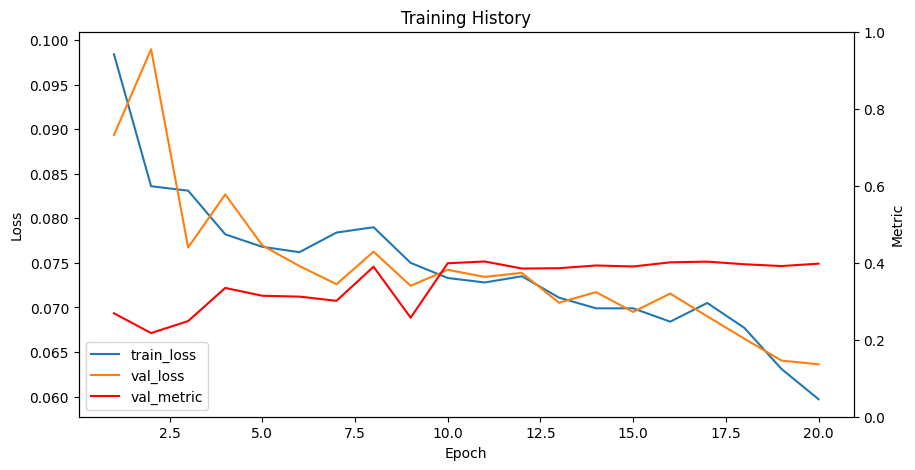

In [45]:
# Get loss, val_loss, and the computed metric from history
loss = [x['loss'] for x in history if 'loss' in x]
val_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

# Get spearman (for regression) or accuracy value (for classification)
if [x['eval_spearmanr'] for x in history if 'eval_spearmanr' in x] != []:
    metric = [x['eval_spearmanr'] for x in history if 'eval_spearmanr' in x]
else:
    metric = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]

epochs = [x['epoch'] for x in history if 'loss' in x]

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

# Plot loss and val_loss on the first y-axis
line1 = ax1.plot(epochs, loss, label='train_loss')
line2 = ax1.plot(epochs, val_loss, label='val_loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Plot the computed metric on the second y-axis
line3 = ax2.plot(epochs, metric, color='red', label='val_metric')
ax2.set_ylabel('Metric')
ax2.set_ylim([0, 1])

# Combine the lines from both y-axes and create a single legend
lines = line1 + line2 + line3
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='lower left')

# Show the plot
plt.title("Training History")
plt.show()

# Save and Load the finetuned model

In [22]:
def save_model(model,filepath):
# Saves all parameters that were changed during finetuning

    # Create a dictionary to hold the non-frozen parameters
    non_frozen_params = {}

    # Iterate through all the model parameters
    for param_name, param in model.named_parameters():
        # If the parameter has requires_grad=True, add it to the dictionary
        if param.requires_grad:
            non_frozen_params[param_name] = param

    # Save only the finetuned parameters 
    torch.save(non_frozen_params, filepath)

    
def load_model(checkpoint, filepath, num_labels=1, mixed = True, full = False, deepspeed = True):
# Creates a new PT5 model and loads the finetuned weights from a file

    # load model
    if "esm" in checkpoint:
        model, tokenizer = load_esm_model(checkpoint, num_labels, mixed, full, deepspeed)
    else:
        model, tokenizer = load_T5_model(checkpoint, num_labels, mixed, full, deepspeed)
        
    # Load the non-frozen parameters from the saved file
    non_frozen_params = torch.load(filepath)

    # Assign the non-frozen parameters to the corresponding parameters of the model
    for param_name, param in model.named_parameters():
        if param_name in non_frozen_params:
            param.data = non_frozen_params[param_name].data

    return tokenizer, model

This saves only the finetuned weights to a .pth file

The file has a size of only a few MB, while the entire model would be around 4.8 GB

In [23]:
save_model(model, "./ankh_large_GB1_finetuned.pth")

To load the weights again, we initialize a new PT5 model from the pretrained checkpoint and load the LoRA weights afterwards

You need to specifiy the correct num_labels here

In [24]:
tokenizer, model_reload = load_model(checkpoint, "./ankh_large_GB1_finetuned.pth", num_labels=1)

loading configuration file config.json from cache at /home/hice1/vraghavan40/.cache/huggingface/hub/models--ElnaggarLab--ankh-large/snapshots/74b371dbfa3ee0a05d32ae74df0c2e0b82d6b9a6/config.json
Model config T5Config {
  "_name_or_path": "agemagician/protx-large-1gspan-partreconstruction-20mlmp-encl48-decl24-ramd128-ranb64-dmodel1536-resume-17",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3840,
  "d_kv": 64,
  "d_model": 1536,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.0,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "num_decoder_layers": 24,
  "num_heads": 16,
  "num_layers": 48,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 64,
  "tie_word_embeddings": false,
  "torch_dtype": "float32",
  "transforme

All the weights of T5EncoderModel were initialized from the model checkpoint at ElnaggarLab/ankh-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use T5EncoderModel for predictions without further training.
loading file spiece.model from cache at None
loading file tokenizer.json from cache at /home/hice1/vraghavan40/.cache/huggingface/hub/models--ElnaggarLab--ankh-large/snapshots/74b371dbfa3ee0a05d32ae74df0c2e0b82d6b9a6/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /home/hice1/vraghavan40/.cache/huggingface/hub/models--ElnaggarLab--ankh-large/snapshots/74b371dbfa3ee0a05d32ae74df0c2e0b82d6b9a6/special_tokens_map.json
loading file tokenizer_config.json from cache at /home/hice1/vraghavan40/.cache/huggingface/hub/models--ElnaggarLab--ankh-large/snapshots/74b371dbfa3ee0a05d32ae74df0c2e0b82d6b9a6/tokenizer_config.json


T5_Classfier
Trainable Parameter: 1154070017
T5_LoRA_Classfier
Trainable Parameter: 4329473



In [78]:
tokenizer, model_reload = load_model(checkpoint, "./ProtT5_GB1_finetuned.pth", num_labels=1)

config.json:   0%|          | 0.00/849 [00:00<?, ?B/s]

loading configuration file config.json from cache at /home/hice1/vraghavan40/.cache/huggingface/hub/models--ElnaggarLab--ankh-large/snapshots/74b371dbfa3ee0a05d32ae74df0c2e0b82d6b9a6/config.json
Model config T5Config {
  "_name_or_path": "agemagician/protx-large-1gspan-partreconstruction-20mlmp-encl48-decl24-ramd128-ranb64-dmodel1536-resume-17",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3840,
  "d_kv": 64,
  "d_model": 1536,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.0,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "num_decoder_layers": 24,
  "num_heads": 16,
  "num_layers": 48,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 64,
  "tie_word_embeddings": false,
  "torch_dtype": "float32",
  "transforme

pytorch_model.bin:   0%|          | 0.00/7.52G [00:00<?, ?B/s]

KeyboardInterrupt: 

To check if the original and the reloaded models are identical we can compare weights

In [25]:
# Put both models to the same device
model=model.to("cpu")
model_reload=model_reload.to("cpu")

# Iterate through the parameters of the two models and compare the data
for param1, param2 in zip(model.parameters(), model_reload.parameters()):
    if not torch.equal(param1.data, param2.data):
        print("Models have different weights")
        break
else:
    print("Models have identical weights")

Models have identical weights


# Make predictions on a test set

In [21]:
# For this we import the "three_vs_rest" GB1 dataset again 
# from https://github.com/J-SNACKKB/FLIP

import requests
import zipfile
from io import BytesIO

# Download the zip file from GitHub
url = 'https://github.com/J-SNACKKB/FLIP/raw/main/splits/gb1/splits.zip'
response = requests.get(url)
zip_file = zipfile.ZipFile(BytesIO(response.content))

# Load the `three_vs_rest.csv` file into a pandas dataframe
with zip_file.open('splits/three_vs_rest.csv') as file:
    df = pd.read_csv(file)

This time we take the test data

In [22]:
# Select only test data
my_test=df[df.set=="test"]

# Set column names to "sequence" and "label"
my_test.columns=["sequence","label"]+list(my_test.columns[2:])

# Drop unneeded columns
my_test=my_test[["sequence","label"]]
print(my_test.head(5))

# Preprocess sequences
my_test["sequence"]=my_test["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
my_test['sequence']=my_test.apply(lambda row : " ".join(row["sequence"]), axis = 1)


                                               sequence     label
2990  MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGAAAEWTYD...  1.611610
2991  MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGAACEWTYD...  3.741833
2992  MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGAAEEWTYD...  0.000000
2993  MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGAAFEWTYD...  1.081518
2994  MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGAAFEWTYD...  2.087250


## Hackathon Test

In [26]:
df_test = pd.read_csv('../test.csv')
mutant_list = list(df_test["mutant"])
df_test['sequence'] = df_test.mutant.apply(lambda x: get_mutated_sequence(x, sequence_wt))
df_test['sequence']=df_test.apply(lambda row : " ".join(row["sequence"]), axis = 1)
df_test

,mutant,sequence
0,V1D,M D N E A R G N S S L N P C L E G S A S S G S ...
1,V1Y,M Y N E A R G N S S L N P C L E G S A S S G S ...
2,V1C,M C N E A R G N S S L N P C L E G S A S S G S ...
3,V1A,M A N E A R G N S S L N P C L E G S A S S G S ...
4,V1E,M E N E A R G N S S L N P C L E G S A S S G S ...
...,...,...
11319,P655S,M V N E A R G N S S L N P C L E G S A S S G S ...
11320,P655T,M V N E A R G N S S L N P C L E G S A S S G S ...
11321,P655V,M V N E A R G N S S L N P C L E G S A S S G S ...
11322,P655A,M V N E A R G N S S L N P C L E G S A S S G S ...


Then we create predictions on our test data using the model we trained before

In [27]:
def create_dataset_test(tokenizer,seqs, index):
    tokenized = tokenizer(seqs, max_length=1024, padding=True, truncation=True)
    dataset = Dataset.from_dict(tokenized)
    dataset = dataset.add_column("index", index)

    return dataset

In [29]:
val_set = create_dataset(tokenizer,list(my_valid['sequence']), my_valid["label"])
test_set = create_dataset_test(tokenizer,list(df_test['sequence']),df_test.index.to_list())

In [30]:
print(val_set["input_ids"])
print(test_set["input_ids"])

[[19, 6, 17, 9, 3, 8, 5, 17, 7, 7, 4, 17, 13, 22, 4, 9, 5, 7, 3, 7, 7, 5, 7, 9, 7, 7, 14, 10, 7, 7, 8, 22, 7, 11, 13, 5, 4, 10, 13, 9, 8, 20, 9, 8, 4, 8, 9, 14, 19, 8, 8, 8, 4, 9, 7, 5, 10, 14, 21, 15, 7, 4, 9, 15, 15, 13, 13, 8, 11, 3, 9, 5, 3, 6, 17, 4, 12, 7, 8, 15, 10, 8, 19, 3, 3, 5, 5, 13, 4, 18, 12, 10, 6, 11, 21, 20, 13, 3, 5, 10, 13, 5, 7, 10, 14, 9, 11, 7, 7, 19, 19, 12, 3, 7, 11, 3, 6, 17, 18, 22, 5, 4, 9, 11, 12, 4, 20, 19, 11, 22, 22, 8, 16, 8, 4, 9, 9, 12, 11, 5, 20, 4, 20, 14, 3, 14, 16, 4, 5, 4, 14, 17, 12, 19, 3, 4, 8, 5, 10, 13, 12, 5, 10, 16, 21, 9, 9, 9, 9, 5, 5, 15, 17, 18, 3, 6, 10, 4, 6, 14, 20, 12, 8, 7, 9, 15, 5, 10, 18, 15, 10, 12, 22, 6, 3, 5, 18, 13, 14, 5, 20, 13, 9, 3, 5, 7, 15, 9, 3, 10, 4, 14, 20, 4, 14, 9, 14, 6, 7, 3, 5, 3, 10, 15, 12, 12, 11, 16, 4, 15, 15, 9, 3, 10, 11, 15, 15, 8, 15, 6, 14, 3, 22, 11, 10, 19, 5, 12, 11, 22, 13, 12, 8, 13, 5, 12, 15, 13, 12, 16, 5, 18, 20, 7, 4, 8, 16, 4, 6, 14, 4, 7, 14, 4, 9, 6, 13, 16, 9, 12, 14, 10, 6, 12, 9, 13,

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [46]:
#Use reloaded model
model_2 = model_reload
model_2 = model
#del model_reload

# Set the device to use
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_2.to(device)

# create Dataset
test_set=create_dataset_test(tokenizer,list(df_test['sequence']),df_test.index.to_list())
# make compatible with torch DataLoader
test_set = test_set.with_format("torch", device=device)

# Create a dataloader for the test dataset
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False)

# Put the model in evaluation mode
model_2.eval()

# Make predictions on the test dataset
predictions = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        #add batch results(logits) to predictions
        predictions += model_2.float()(input_ids, attention_mask=attention_mask).logits.tolist()

100%|██████████| 708/708 [13:42<00:00,  1.16s/it]


In [41]:
mutant_list2 = []
for batch in tqdm(test_dataloader):
    indexs = batch["index"]
    for idx in indexs:
        mutant_list2.append(df_test["mutant"][idx.cpu().numpy()])


100%|██████████| 708/708 [00:03<00:00, 208.93it/s]


In [33]:
predictions

[[0.21831871569156647],
 [0.2205090969800949],
 [0.2187747210264206],
 [0.21920809149742126],
 [0.2194698005914688],
 [0.21972990036010742],
 [0.2182072401046753],
 [0.21802854537963867],
 [0.21889625489711761],
 [0.21879154443740845],
 [0.21829530596733093],
 [0.2194138765335083],
 [0.22066952288150787],
 [0.21746081113815308],
 [0.21912474930286407],
 [0.2193438857793808],
 [0.21950462460517883],
 [0.2206079214811325],
 [0.2191464602947235],
 [0.21727895736694336],
 [0.21977399289608002],
 [0.21703855693340302],
 [0.21997573971748352],
 [0.21934852004051208],
 [0.21968930959701538],
 [0.21922944486141205],
 [0.21982300281524658],
 [0.21940532326698303],
 [0.21934421360492706],
 [0.2196146547794342],
 [0.2209831029176712],
 [0.21954460442066193],
 [0.2201852798461914],
 [0.21702010929584503],
 [0.2198072373867035],
 [0.21774393320083618],
 [0.22014296054840088],
 [0.21993747353553772],
 [0.21665486693382263],
 [0.21734482049942017],
 [0.21917156875133514],
 [0.21879544854164124],
 [0.

In [42]:
mutant_list == mutant_list2

True

In [34]:
set([x[0] for x in predictions])

{0.21831871569156647,
 0.2205090969800949,
 0.2194698005914688,
 0.2187747210264206,
 0.21920809149742126,
 0.21972990036010742,
 0.2182072401046753,
 0.21802854537963867,
 0.21889625489711761,
 0.21879154443740845,
 0.21829530596733093,
 0.2194138765335083,
 0.22066952288150787,
 0.21746081113815308,
 0.21912474930286407,
 0.2193438857793808,
 0.21959775686264038,
 0.2183675765991211,
 0.22628319263458252,
 0.2333609014749527,
 0.20979896187782288,
 0.22358106076717377,
 0.21650540828704834,
 0.21881112456321716,
 0.21868640184402466,
 0.2186700999736786,
 0.19949017465114594,
 0.21813641488552094,
 0.21836529672145844,
 0.22191122174263,
 0.2172948122024536,
 0.2187596559524536,
 0.2177983522415161,
 0.2183018922805786,
 0.2210026979446411,
 0.21847429871559143,
 0.2178265005350113,
 0.2190472036600113,
 0.2213360220193863,
 0.2225262075662613,
 0.2187267690896988,
 0.2169109731912613,
 0.2191387563943863,
 0.2190014272928238,
 0.21788176894187927,
 0.21808353066444397,
 0.2193957865

In [47]:
Fine_Tuned_pred_df = pd.DataFrame({'mutant': mutant_list, 'DMS_score_predicted': [x[0] for x in predictions]})

In [48]:
Fine_Tuned_pred_df.to_csv("this_better_work3.csv", index=False)

Finally, we compute our desired performance metric for the test data

In [24]:
# Regression
print(stats.spearmanr(a=predictions, b=my_test.label, axis=0))

# Classification
# we need to determine the prediction class from the logit output
# predictions= [item.argmax() for item in np.array(predictions)]
# print("Accuracy: ", accuracy_score(my_test.label, predictions))


SpearmanrResult(correlation=0.8598781959146417, pvalue=0.0)


Great, 0.86 Spearman is a decent test performance for this dataset (see results in [Table 4](https://openreview.net/pdf?id=p2dMLEwL8tF))

More training epochs and / or hyperparameter optimization will most likely increase performance